# <b>Assignment 1: Predict diabetes using Perceptron</b>




In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import warnings
from tensorflow.keras.optimizers import SGD, Adam, Nadam, RMSprop
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.exceptions import ConvergenceWarning

In [2]:
from helper import *

In [3]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## <b>1: Exploratory Data Analysis (EDA)</b>


### 1.1 Visualization

In [4]:
dataset = pd.read_csv('diabetes.csv')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


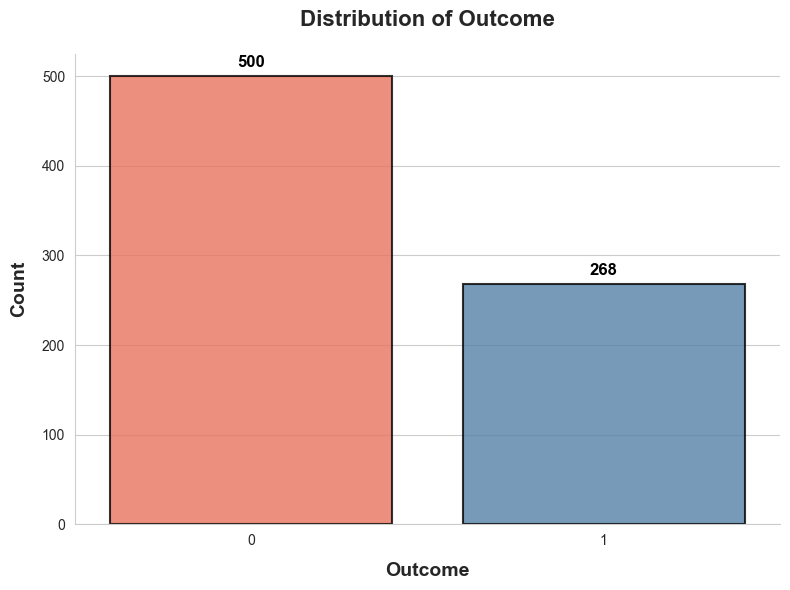

In [6]:
# Set style for the plot
sns.set_style('whitegrid')

# Create a count plot with customized aesthetics
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    x=dataset['Outcome'], 
    palette=['#FF6347', '#4682B4'],
    alpha=0.8,
    edgecolor='black',
    linewidth=1.5
)

# Customize bar labels with more vertical space
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height() + 10),  # Add vertical offset
        ha='center', 
        va='baseline', 
        fontsize=12, 
        color='black', 
        fontweight='bold'
    )

# Set title and labels with improved font sizes and styles
plt.xlabel('Outcome', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Count', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Distribution of Outcome', fontsize=16, fontweight='bold', pad=20)

# Remove top and right borders for a cleaner look
sns.despine(top=True, right=True)

# Show the plot
plt.tight_layout()
plt.show()

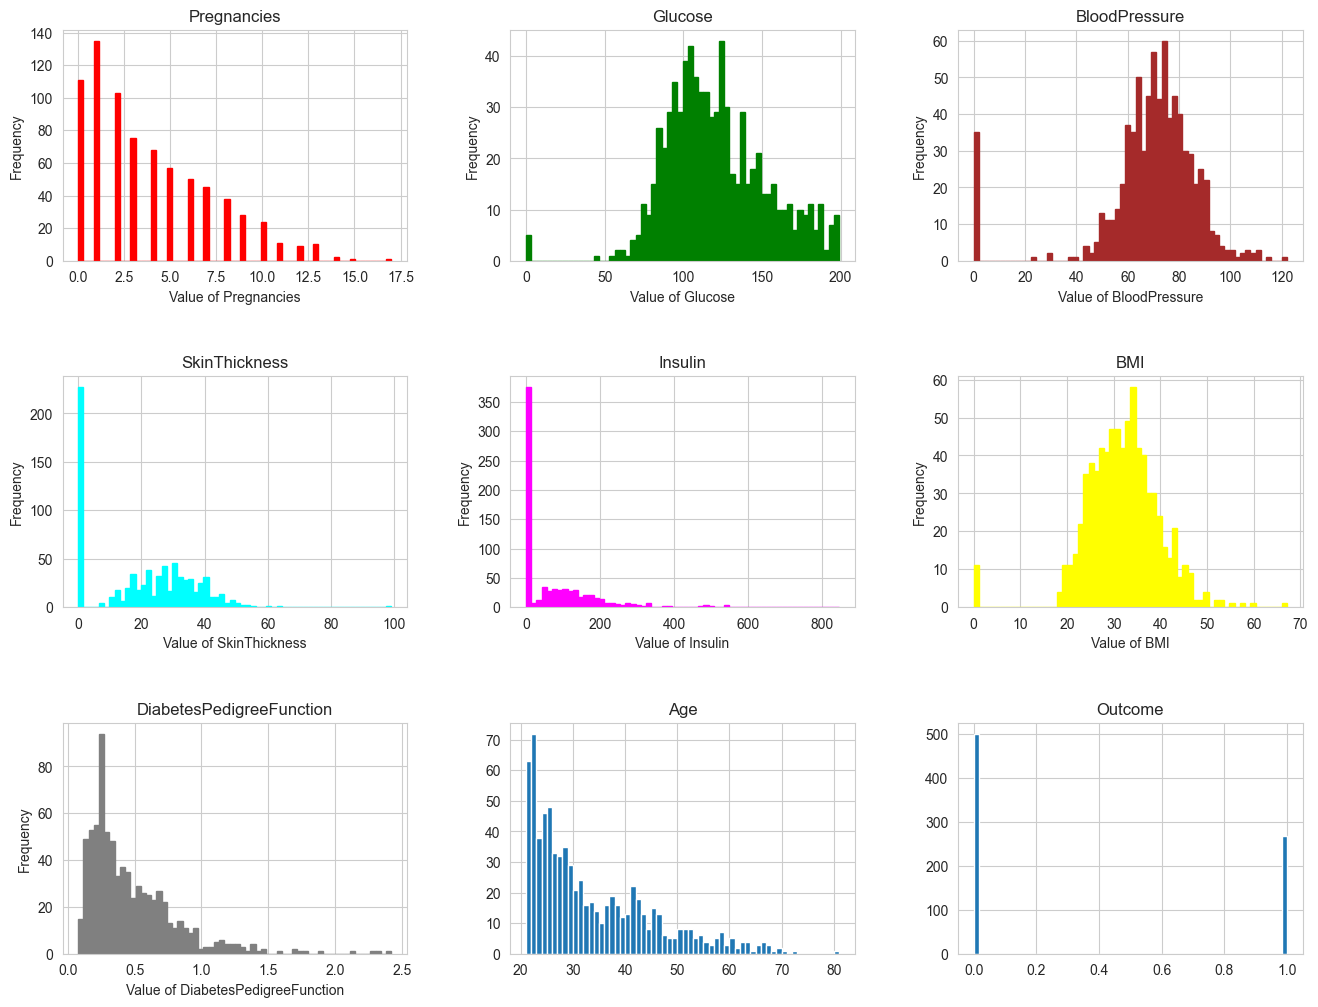

In [7]:
# Visualization using histogram

axes = dataset.hist(bins=60, figsize=(16, 12))
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
colors = ['red', 'green', 'brown', 'cyan', 'magenta', 'yellow', 'grey']

for ax, feature, color in zip(axes.flatten(), features, colors):
    ax.set_xlabel('Value of ' + feature)
    ax.set_ylabel('Frequency')
    
    for elem in ax.patches:
        elem.set_color(color)

plt.subplots_adjust(hspace=0.5)
plt.show()

### 1.2 Data Pre-processing

In [8]:
# Remove 0 from Glucose, BloodPressure, SkinThickness, Insulin, BMI
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
dataset[columns_to_impute] = dataset[columns_to_impute].replace(0, np.nan)

In [9]:
dataset.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [10]:
# Define X and y variables
X = dataset.drop('Outcome', axis=1) # feature variable
y = dataset['Outcome'].copy() # target variables

X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47


In [11]:
# Preprocessing pipeline with imputation and scaling
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])

columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

X_transformed = pipeline.fit_transform(X)
X_new = pd.DataFrame(X_transformed, columns=X.columns)
X_new

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.6,0.765432,0.000,0.857143,0.000000,0.142857,0.665359,1.235294
1,-0.4,-0.790123,-0.375,0.000000,0.000000,-0.626374,-0.056209,0.117647
2,1.0,1.629630,-0.500,0.000000,0.000000,-0.989011,0.783007,0.176471
3,-0.4,-0.691358,-0.375,-0.857143,-5.391304,-0.461538,-0.537255,-0.470588
4,-0.6,0.493827,-2.000,0.857143,7.478261,1.186813,5.007843,0.235294
...,...,...,...,...,...,...,...,...
763,1.4,-0.395062,0.250,2.714286,9.565217,0.065934,-0.526797,2.000000
764,-0.2,0.123457,-0.125,-0.285714,0.000000,0.494505,-0.084967,-0.117647
765,0.4,0.098765,0.000,-0.857143,-2.260870,-0.670330,-0.333333,0.058824
766,-0.4,0.222222,-0.750,0.000000,0.000000,-0.241758,-0.061438,1.058824


In [12]:
# Check NaN values again
check_na = X_new.isna().sum()
check_na

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## <b>2: Predicting with Single Layer Perceptron (SLP)</b>

### 2.1 Baseline Model

In [15]:
# Baseline model of a single-layer Perceptron using TensorFlow
def baseline_model(activation_function='softmax', loss_function='sparse_categorical_crossentropy', optimizer='SGD', learning_rate=0.001, **kwargs):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, activation=activation_function, input_shape=(X_train.shape[1],))  # Softmax for binary classification
    ])
    
    # Ensure optimizer instance is created correctly even when default parameter is used
    if isinstance(optimizer, str):
        optimizer_instance = tf.keras.optimizers.get({'class_name': optimizer, 'config': {'learning_rate': learning_rate}})
    else:
        optimizer_instance = optimizer

    model.compile(optimizer=optimizer_instance, loss=loss_function, metrics=['accuracy'])
    return model

In [16]:
# Number of epochs
num_epochs = 100

bl_model = baseline_model()

# Train the baseline model
history_bl = bl_model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val))

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3226 - loss: 4.1054 - val_accuracy: 0.4228 - val_loss: 4.7986
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3630 - loss: 4.0953 - val_accuracy: 0.4146 - val_loss: 4.1091
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3184 - loss: 3.7207 - val_accuracy: 0.4146 - val_loss: 3.4076
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3596 - loss: 2.7891 - val_accuracy: 0.4146 - val_loss: 2.7299
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3466 - loss: 2.1970 - val_accuracy: 0.3984 - val_loss: 2.1034
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3345 - loss: 1.9427 - val_accuracy: 0.4065 - val_loss: 1.5513
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3528 - loss: 1.3042 - val_accuracy: 0.3984 - val_loss: 1.1942
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3469 - loss: 1.1176 - val_accuracy: 0.4146 - v

Baseline Model Evaluation:
Test Loss: 0.6391 - Test Accuracy: 0.6299
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.6683 - loss: 0.5981
Accuracy:  0.6298701298701299
Precision:  0.47368421052631576
Recall:  0.32727272727272727
F1 Score:  0.3870967741935484

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.80      0.73        99
           1       0.47      0.33      0.39        55

    accuracy                           0.63       154
   macro avg       0.58      0.56      0.56       154
weighted avg       0.61      0.63      0.61       154



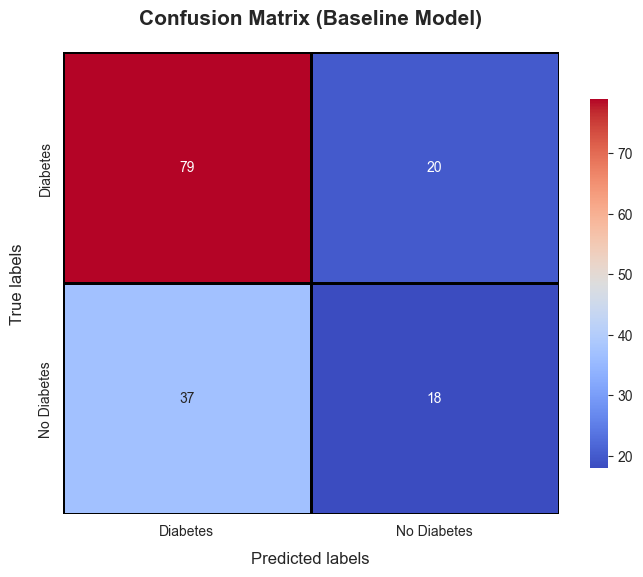

In [17]:
print('Baseline Model Evaluation:')
accuracy_bl = evaluate_model(bl_model, X_test, y_test, 'Baseline Model')

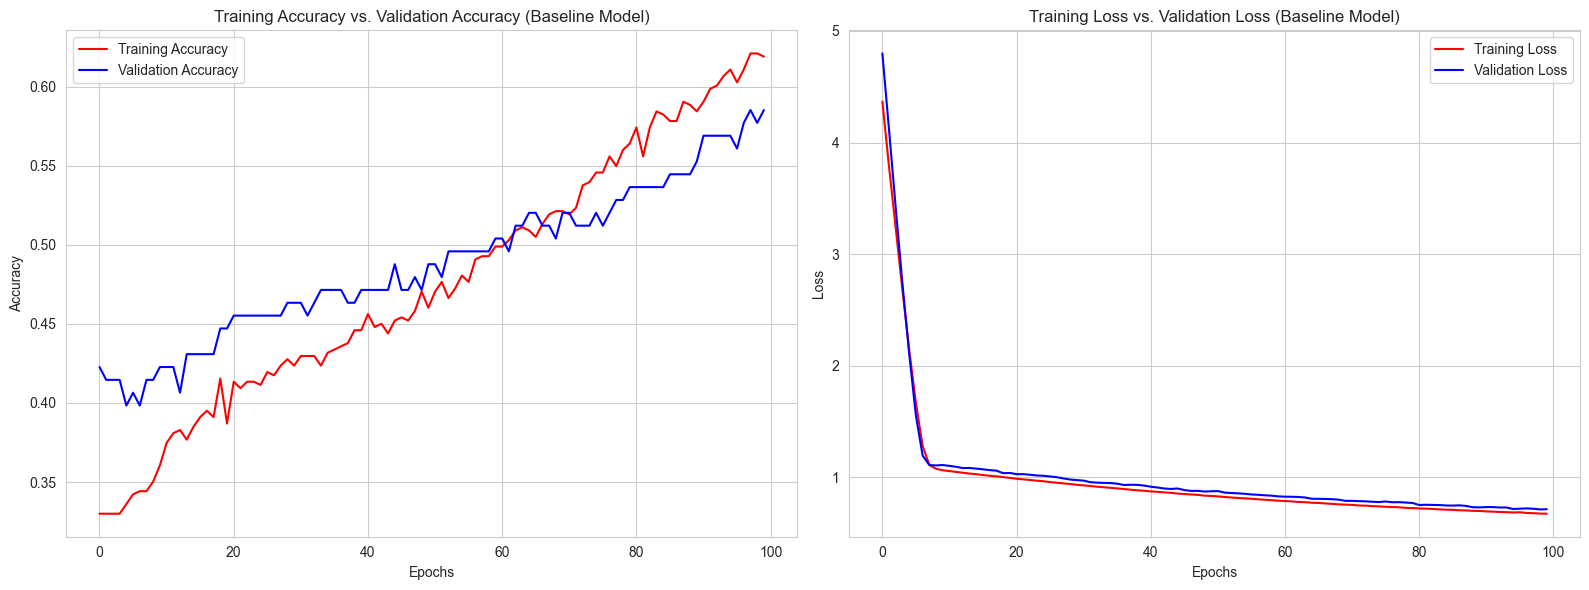

In [18]:
# Plot the learning curves
plot_learning_curves(history_bl, 'Baseline Model')

In [19]:
flops_single_perceptron = calculate_flops_from_model(bl_model)
gflops_single_perceptron = to_gflops(flops_single_perceptron)
efficiency_bl = accuracy_bl/flops_single_perceptron

print(f'Single Perceptron Model FLOPs: {flops_single_perceptron}')
print(f'Single Perceptron Model GFLOPs: {gflops_single_perceptron}')
print(f'Accuracy Baseline Model: {accuracy_bl}')
print(f'Baseline Model Efficiency: {efficiency_bl}')

Single Perceptron Model FLOPs: 34
Single Perceptron Model GFLOPs: 3.4e-08
Accuracy Baseline Model: 0.6298701298701299
Baseline Model Efficiency: 0.01852559205500382


### 2.2 Experiment: Hyperparameter Tuning with GridSearchCV

In [20]:
model = KerasClassifier(model=baseline_model, epochs=50, batch_size=32, verbose=0)

In [21]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

/Users/quocanh/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/quocanh/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/quocanh/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

Experiment - Hyperparameter Tuning:
Best: 0.7781 using {'batch_size': 32, 'epochs': 50, 'model__activation': 'softmax', 'model__learning_rate': 0.01, 'model__loss_function': 'sparse_categorical_crossentropy', 'model__optimizer': 'RMSprop'}
Test Loss: 0.5190 - Test Accuracy: 0.7468
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.7211 - loss: 0.5353
Accuracy:  0.7467532467532467
Precision:  0.6481481481481481
Recall:  0.6363636363636364
F1 Score:  0.6422018348623854

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.80        99
           1       0.65      0.64      0.64        55

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



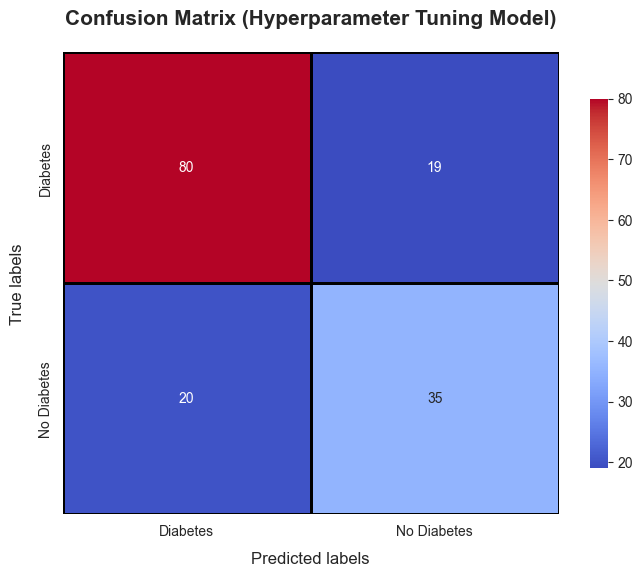

In [22]:
# Print the best parameters and score
print('Experiment - Hyperparameter Tuning:')
print(f'Best: {grid_result.best_score_:.4f} using {grid_result.best_params_}')

# Evaluate the best model on the test set
best_model = grid_result.best_estimator_.model_
accuracy_gridsearch_perceptron = evaluate_model(best_model, X_test, y_test, model_name='Hyperparameter Tuning Model')

In [23]:
# Extract the best parameters from GridSearchCV results
best_params = grid_result.best_params_

# Use the best parameters to create the best model using the modified baseline_model function
best_model = baseline_model(
    activation_function=best_params['model__activation'],
    learning_rate=best_params['model__learning_rate'],
    optimizer=best_params['model__optimizer']
)

In [24]:
history_gridsearch = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size']
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6637 - loss: 1.9215 - val_accuracy: 0.6753 - val_loss: 1.0720
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6937 - loss: 1.1255 - val_accuracy: 0.6948 - val_loss: 0.6288
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6859 - loss: 0.6533 - val_accuracy: 0.7273 - val_loss: 0.5175
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7169 - loss: 0.5309 - val_accuracy: 0.7468 - val_loss: 0.5244
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7412 - loss: 0.5152 - val_accuracy: 0.7338 - val_loss: 0.4922
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7245 - loss: 0.5111 - val_accuracy: 0.7468 - val_loss: 0.4950
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7817 - loss: 0.4587 - val_accuracy: 0.7338 - val_loss: 0.5533
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7197 - loss: 0.5025 - val_accuracy: 0.7468 - val_loss:

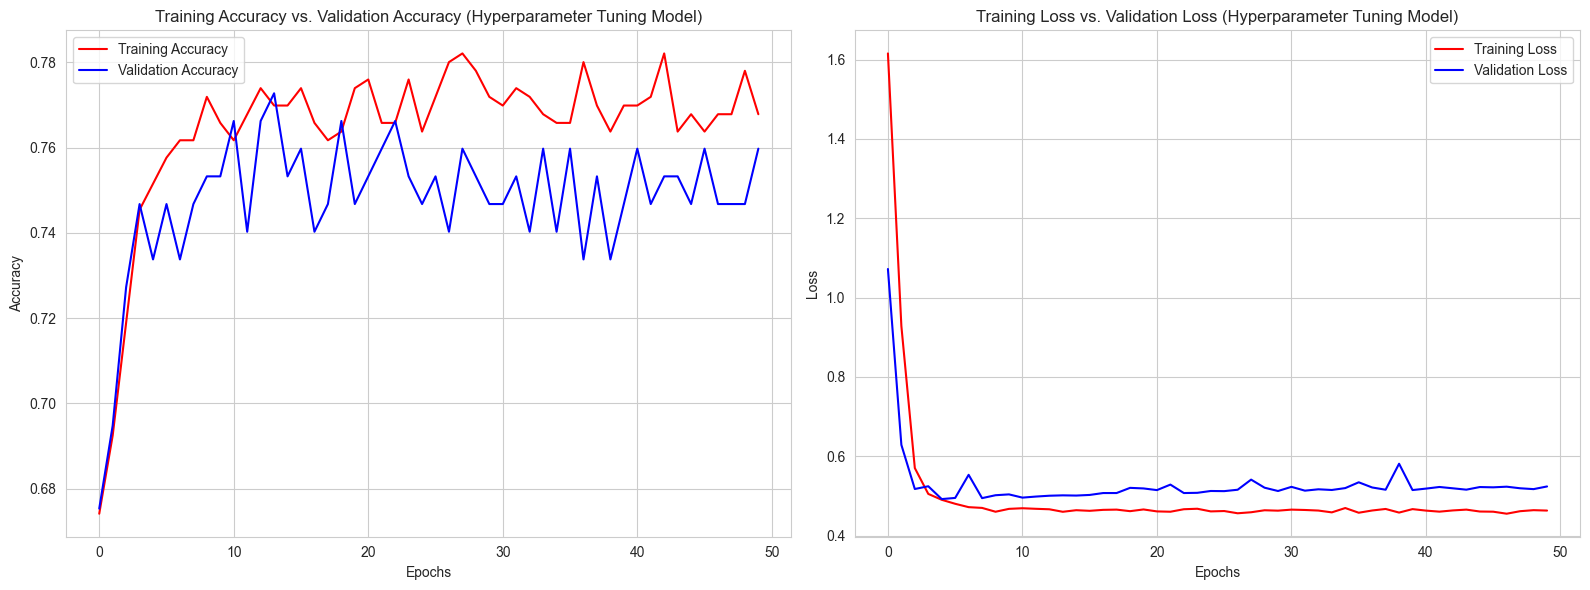

In [25]:
# Plot the learning curves
plot_learning_curves(history_gridsearch, 'Hyperparameter Tuning Model')

In [27]:
# Assuming best_model is defined from GridSearchCV
flops_gridsearch_perceptron = calculate_flops_from_model(best_model)
gflops_gridsearch_perceptron = to_gflops(flops_gridsearch_perceptron)
efficiency_gridsearch_perceptron = accuracy_gridsearch_perceptron/flops_gridsearch_perceptron

print(f'GridSearchCV Perceptron Model FLOPs: {flops_gridsearch_perceptron}')
print(f'GridSearchCV Perceptron Model GFLOPs: {gflops_gridsearch_perceptron}')
print(f'Accuracy GridSearchCV Perceptron Model: {accuracy_gridsearch_perceptron}')
print(f'GridSearchCV Perceptron Model Efficiency: {efficiency_gridsearch_perceptron}')

GridSearchCV Perceptron Model FLOPs: 34
GridSearchCV Perceptron Model GFLOPs: 3.4e-08
Accuracy GridSearchCV Perceptron Model: 0.7467532467532467
GridSearchCV Perceptron Model Efficiency: 0.021963330786860198


## <b>3: Predicting with Multi-layer Perceptron (MLP)</b>

In [28]:
# Define the MLP model in TensorFlow
def mlp_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
        tf.keras.layers.Dense(512, activation='relu'),  # Second hidden layer
        tf.keras.layers.Dense(256, activation='relu'),  # New third hidden layer
        tf.keras.layers.Dense(256, activation='relu'),  # New fourth hidden layer
        tf.keras.layers.Dense(128, activation='relu'),  # New fifth hidden layer
        tf.keras.layers.Dense(10, activation='softmax')  # Output layer
    ])
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [29]:
# Create the MLP model
mlp_model_instance = mlp_model()

# Train the MLP model on the dataset
num_epochs = 500
history_mlp = mlp_model_instance.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val))

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 6.3486e-04 - loss: 2.3889 - val_accuracy: 0.0569 - val_loss: 2.2645
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0867 - loss: 2.2388 - val_accuracy: 0.3252 - val_loss: 2.1287
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4274 - loss: 2.1354 - val_accuracy: 0.6016 - val_loss: 2.0402
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5964 - loss: 2.0521 - val_accuracy: 0.6098 - val_loss: 1.9746
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6595 - loss: 1.9888 - val_accuracy: 0.6098 - val_loss: 1.9179
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6398 - loss: 1.9189 - val_accuracy: 0.6098 - val_loss: 1.8681
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6440 - loss: 1.8944 - val_accuracy: 0.6098 - val_loss: 1.8230
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6679 - loss: 1.8379 - val_accuracy: 0.6260

MLP Model Evaluation:
Test Loss: 0.5362 - Test Accuracy: 0.7403
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x2976de980> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7029 - loss: 0.5427 
Accuracy:  0.7402597402597403
Precision:  0.631578947368421
Recall:  

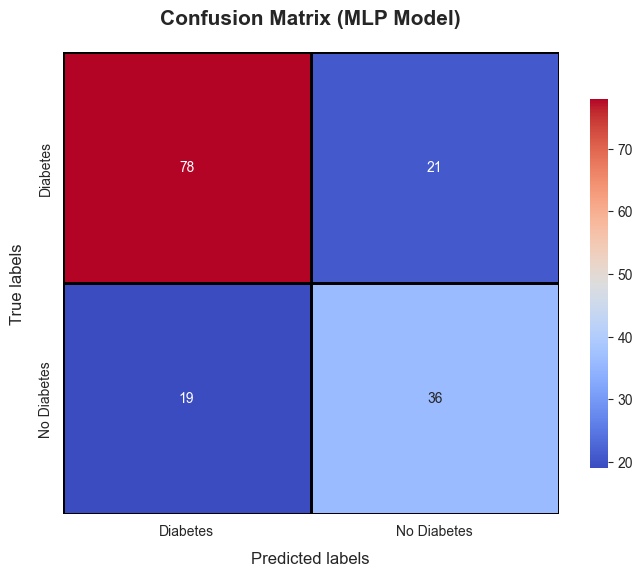

In [30]:
# Evaluate the MLP model on the test set
print('MLP Model Evaluation:')
accuracy_mlp = evaluate_model(mlp_model_instance, X_test, y_test, 'MLP Model')

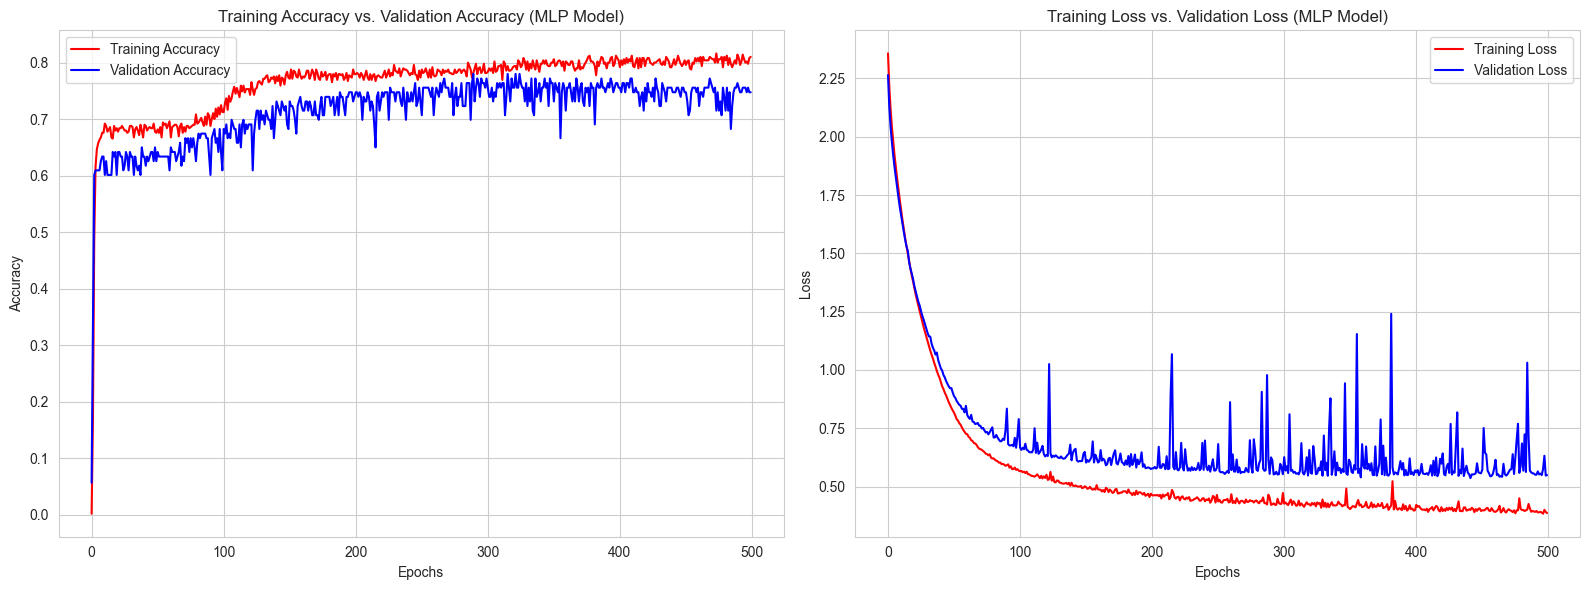

In [31]:
# Plot the learning curves
plot_learning_curves(history_mlp, 'MLP Model')

In [32]:
flops_mlp = calculate_flops_from_model(mlp_model_instance)
gflops_mlp = to_gflops(flops_mlp)
efficiency_mlp = accuracy_mlp/flops_mlp

print(f'MLP Model FLOPs: {flops_mlp}')
print(f'MLP Model GFLOPs: {gflops_mlp}')
print(f'Accuracy MLP Model: {accuracy_mlp}')
print(f'MLP Model Efficiency: {efficiency_mlp}')

MLP Model FLOPs: 995466
MLP Model GFLOPs: 0.000995466
Accuracy MLP Model: 0.7402597402597403
MLP Model Efficiency: 7.43631364868052e-07


## <b>4: Predicting with Residual Multi-Layer Perceptrons</b>

In [38]:
# Define the MLP model with residual connections in TensorFlow
def residual_mlp_model():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    
    # First hidden layer
    x = tf.keras.layers.Dense(512, activation='relu')(inputs)
    
    # Second hidden layer with residual connection
    x_shortcut = x  # Save the input for residual connection
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.add([x, x_shortcut])  # Add residual connection
    
    # Third hidden layer
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    # Fourth hidden layer with residual connection
    x_shortcut = x  # Save the input for residual connection
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.add([x, x_shortcut])  # Add residual connection

    # Output layer
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [39]:
# Create the residual MLP model
residual_model = residual_mlp_model()

# Train the model
history_residual = residual_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5080 - loss: 1.8039 - val_accuracy: 0.6260 - val_loss: 1.5757
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7249 - loss: 1.4936 - val_accuracy: 0.6341 - val_loss: 1.4178
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7026 - loss: 1.3573 - val_accuracy: 0.6260 - val_loss: 1.3940
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7087 - loss: 1.3176 - val_accuracy: 0.6667 - val_loss: 1.2962
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7037 - loss: 1.2319 - val_accuracy: 0.6341 - val_loss: 1.2552
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7007 - loss: 1.2117 - val_accuracy: 0.6585 - val_loss: 1.2116
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7120 - loss: 1.1456 - val_accuracy: 0.6179 - val_loss: 1.2325
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7201 - loss: 1.1508 - val_accuracy: 0.6423 - v

MLP Residual Model Evaluation:
Test Loss: 0.5527 - Test Accuracy: 0.7403
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7151 - loss: 0.5514 
Accuracy:  0.7402597402597403
Precision:  0.6229508196721312
Recall:  0.6909090909090909
F1 Score:  0.6551724137931034

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79        99
           1       0.62      0.69      0.66        55

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154



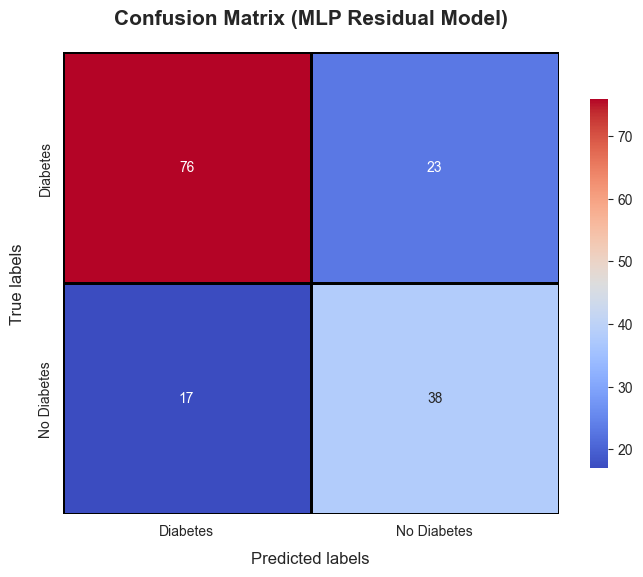

In [40]:
# Evaluate the MLP model on the test set
print('MLP Residual Model Evaluation:')
accuracy_mlp_residual = evaluate_model(residual_model, X_test, y_test, 'MLP Residual Model')

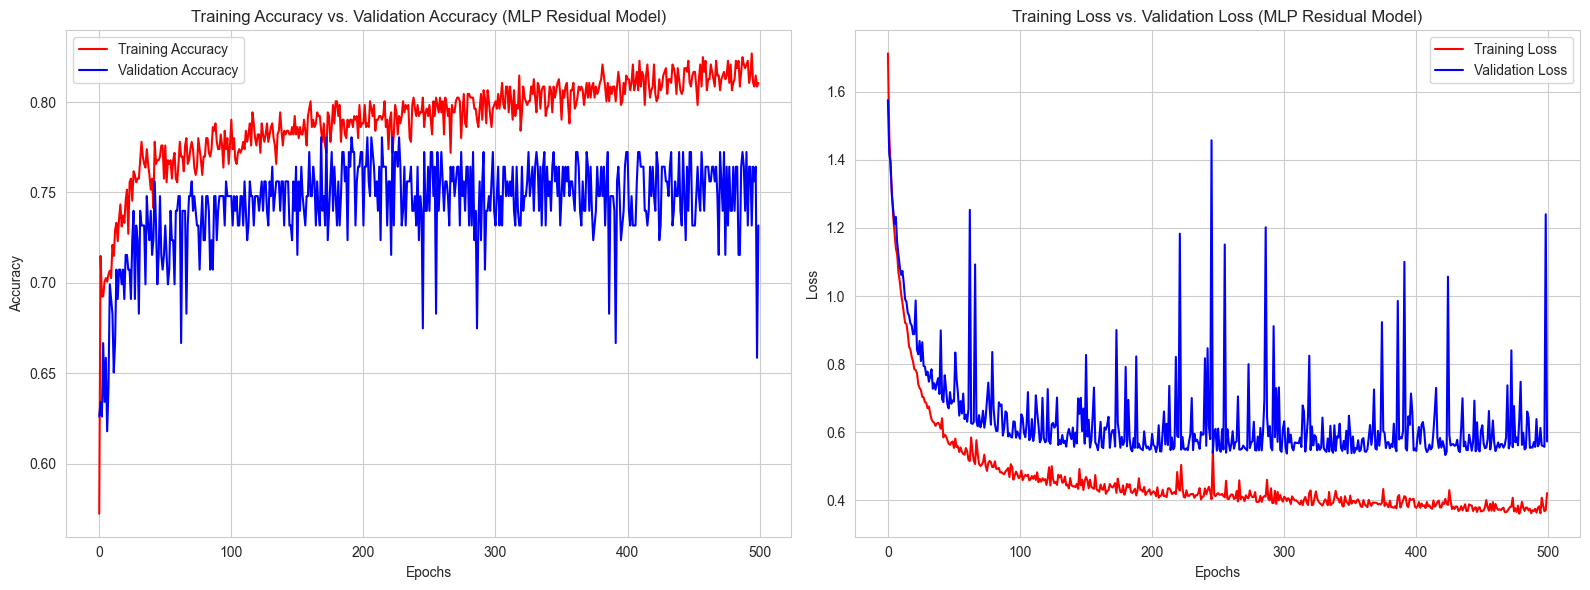

In [41]:
# Plot the learning curves
plot_learning_curves(history_residual, 'MLP Residual Model')

In [37]:
flops_mlp_residual = calculate_flops_from_model(residual_model)
gflops_mlp_residual = to_gflops(flops_mlp_residual)
efficiency_mlp_residual = accuracy_mlp_residual/flops_mlp_residual

print(f'MLP Residual Model FLOPs: {flops_mlp_residual}')
print(f'MLP Residual Model GFLOPs: {gflops_mlp_residual}')
print(f'Accuracy MLP Residual Model: {accuracy_mlp_residual}')
print(f'MLP Model Efficiency: {efficiency_mlp_residual}')

MLP Residual Model FLOPs: 932362
MLP Residual Model GFLOPs: 0.000932362
Accuracy MLP Residual Model: 0.7077922077922078
MLP Model Efficiency: 7.591388406994362e-07
